# Support vector machine, part 3: kernels

## Introduction 

In this third part, we study the kernel trick to implement support vector machines with non-linear boundaries. This allows us to embed our dataset in higher dimensional spaces, including infinite dimensional Hilbert spaces. This is done without using the explicit embedding but rather the inner products between the image of the data points. The main idea is that in the higher dimensional space, the new features that capture the underlying relations between data points and responses. 

## Embedding in higher dimensions

Suppose we have a dataset $S = \{(x^1,y^1),\dots,(x^m,y^m) \}\subset \mathbb{R}^n\times\{-1,1\}$ consisting of pairs (features,class). Let $\mathcal{H}$ be a real Hilbert space endowed with an inner product $(\cdot,\cdot)_\mathcal{H}\colon\mathcal{H}\times\mathcal{H}\to\mathbb{R}$. We will denote $(x,y)_\mathcal{H} = x\cdot y$. Suppose that we have an embedding $\varphi\colon\mathbb{R}^n\to\mathcal{H}$. 

## Linear SVM in $\mathcal{H}$

Now that we have embedded the data into $\mathcal{H}$, we use a linear SVM (with soft margin) to separate the datasets in two classes. For this, our new dataset is $\{(\varphi(x^1),y^1),\ldots,(\varphi(x^m),y^m) \}$. From the previous notebook, the optimization problem is then:

## Implementation

In this section we implement the algorithm described above. We start by implementing the usual scientific libraries. This time, we will use `scipy` minimizing tool:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

![](http://)We generate two classes of points which are linearly separable. We fix a seed of random numbers so we always get the same dataset:

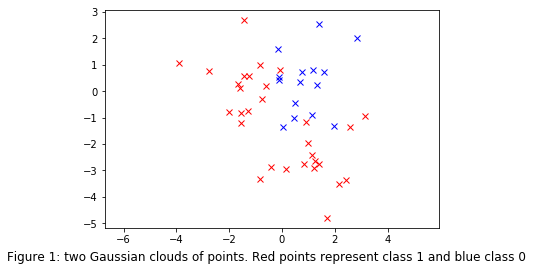

In [2]:
np.random.seed(2)
class_0 = 15 
class_1 = 15

x0 = np.random.multivariate_normal([-2, 0], [[1, .15],[.15, 1]], class_0)
x1 = np.random.multivariate_normal([1, 0], [[1, .25],[.25, 1]], class_1)
x2 = np.random.multivariate_normal([1, -3], [[1, .25],[.25, 1]], class_0)

plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.plot(x2[:,0],x2[:,1],'x',color='red')
plt.figtext(0.5, 0.01, 'Figure 1: two Gaussian clouds of points. Red points represent class 1 and blue class 0', 
            wrap=True, horizontalalignment='center', fontsize=12)
plt.axis('equal')
plt.show()

y0 = -np.ones(len(x0))
y1 = np.ones(len(x1))
y2 = -np.ones(len(x2))

X_train =  np.vstack((np.vstack((x0,x1)),x2))
y_train = np.append(np.append(y0,y1),y2)

We compute the matrix containing the inner products of the points of the dataset. We include different options for different kernels

In [3]:
def inner_prod(x,y,kernel='rbf',c=1,deg = 2):
    if kernel == 'rbf':
        return np.exp((-1/(2*(c**2))*np.dot(x-y,x-y)))
    elif kernel == 'poly':
        return (c+np.dot(x,y))**deg
    else:
        return np.dot(x,y)

In [4]:
#matrix with all training inner products
kernel = 'rbf'
c = 1
deg = 15

H = np.zeros([X_train.shape[0],X_train.shape[0]])
for i in range(len(H)):
    for j in range(len(H)):
        H[i,j] = y_train[i]*y_train[j]*inner_prod(X_train[i,:],X_train[j,:],kernel=kernel,c=c,deg = deg)

With this, we can write the cost function as:

In [5]:
def cost(alpha): 
    return -(np.sum(alpha) - (1/2)*np.dot(alpha,
                                        np.dot(H,alpha)))

We define the constraint given by the KKT conditions. This is of the form $\sum_{i=1}^m \alpha_i y^i = 0$.

In [6]:
def cons1(alpha):
    return np.dot(alpha,y_train)

cons = ({'type': 'eq', 'fun': cons1})

We also set the conditions for the Lagrange multipliers: $C > \alpha_i \geq 0$:

In [8]:
C = 100
bds = [(0,C) for _ in range(len(X_train))]

Now, we need an initial guess for the value of $\alpha_i$ for the optimizer:

In [9]:
alpha = np.random.random(len(X_train))

Finally, we optimize the cost function 

In [10]:
res = minimize(cost, alpha , bounds=bds, constraints=cons)

We recover the values of $\alpha_i$ that optimize the Lagrangian:

In [11]:
alpha = res.x

We will set to zero the values $\alpha_i$ which are smaller than $10^{-7}$:

In [12]:
alpha = alpha*(1*(alpha > 10**(-7)))

In [13]:
alpha*(1*(alpha > 10**(-7)))

array([  0.        ,   2.87683768, 100.        ,   0.        ,
         9.29167568,   0.20167876,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  13.02383098,   0.        ,  24.91246229,
         1.68427975,  97.35861369,  24.70707819,   0.        ,
         0.        ,   0.        ,  15.77523994,   0.        ,
         0.        ,   8.98436149,   0.        ,   0.        ,
         0.        ,  22.66828497,   0.        ,   0.        ,
        15.7406182 ,   0.        ,   0.        ,   0.        ,
         0.        ,  52.82957441,   0.        ,   0.24322937,
         0.        ,   1.88287524,   0.        ,   0.        ,
         0.        ])

We can now construct the parameters $w,b$:

In [14]:
sup_vec, sup_lab = (X_train[(alpha > 0) & (alpha < C)])[0] , (y_train[(alpha > 0) & (alpha < C)])[0]
b = sup_lab 
for i in range(len(X_train)):
    b += -alpha[i]*y_train[i]*inner_prod(sup_vec,X_train[i,:],kernel,c,deg)
#b = y_train[(alpha > 0) & (alpha < C)][0] - np.dot(w,X_train[(alpha > 0) & (alpha < C)][0])

With this, we can build the prediction function:

In [15]:
def predict(x,b,alpha):
    w_dot_phi_x = 0
    for i in range(len(X_train)):
        w_dot_phi_x += alpha[i]*y_train[i]*inner_prod(x,X_train[i,:],kernel,c,deg)
    return np.sign(w_dot_phi_x + b)

Finally, we can plot the decision boundary given by the SVM as well as the regions predicted for each class. We can see how the separating hyperplane maximizes the margin to both classes.

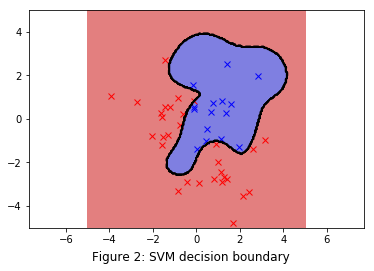

In [16]:
plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.plot(x2[:,0],x2[:,1],'x',color='red')
plt.figtext(0.5, 0.01, 'Figure 2: SVM decision boundary', 
            wrap=True, horizontalalignment='center', fontsize=12)

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
z = np.zeros(X.shape)
Z = np.array(z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = predict(np.array([x[j],y[i]]),b,alpha)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.axis('equal')
plt.show()

We can check the support vectors and plot them together with the separating hyperplane

In [17]:
sup_vect = X_train[alpha > 0]
sup_vect

array([[-1.44947485,  2.68917663],
       [-0.09130799,  0.81118772],
       [-0.60516755,  0.20963153],
       [-3.91249753,  1.07617607],
       [-0.74224566, -0.29070263],
       [-0.15371931,  1.57913572],
       [ 2.85582217,  1.99388338],
       [-0.12546442,  0.53974018],
       [ 1.12022024, -0.91372616],
       [ 0.0452582 , -1.3658609 ],
       [ 0.44251188, -1.02422923],
       [ 1.96730829, -1.3090177 ],
       [ 2.58469139, -1.35865739],
       [ 0.89833321, -1.1610744 ],
       [ 1.69569856, -4.79477916],
       [-0.41635616, -2.88761379]])

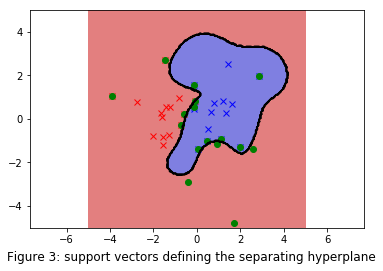

In [18]:
plt.plot(x0[:,0],x0[:,1],'x',color='red')
plt.plot(x1[:,0],x1[:,1],'x',color='blue')
plt.figtext(0.5, 0.01, 'Figure 3: support vectors defining the separating hyperplane', 
            wrap=True, horizontalalignment='center', fontsize=12)

x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, alpha=.5, cmap='jet_r')
C = plt.contour(X, Y, Z,  colors='black',zorder=4)
plt.plot(sup_vect[:,0],sup_vect[:,1],'o',color='green')


plt.axis('equal')
plt.show()

## Final remarks

